In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from odc.geo.xr import xr_reproject, assign_crs
from ocr.conus404 import geo_sel
from ocr.config import OCRConfig
from ocr.pipeline.process_region import sample_risk_to_buildings
# from ocr.risks.fire import calculate_wind_adjusted_risk
from ocr.risks.fire import apply_wind_directional_convolution, create_weighted_composite_bp_map, generate_wind_directional_kernels
from ocr import catalog
import xarray as xr

In [2]:
config = OCRConfig(storage_root='/tmp/ocr-testing', debug=True)
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=True), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/ocr-testing', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=True), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=True)

In [3]:
def classify_wind(
    riley_30m_4326: xr.Dataset,
    wind_direction_distribution_30m_4326: xr.DataArray,
    unburnable_mask_climate_run_30m_4326: xr.DataArray,
    riley_270m_5070: xr.Dataset, 
) -> xr.DataArray:
    """Classify wind by applying directional convolution and creating a weighted composite burn probability map.

    Parameters
    ----------
    climate_run_subset : xr.Dataset
        Subset of the climate run dataset containing burn probability ('BP') data.
    wind_direction_distribution : xr.DataArray
        Wind direction distribution data array.
    unburnable_mask_climate_run : xr.DataArray
        Unburnable mask for the climate run dataset.

    Returns
    -------
    wind_informed_bp_float_corrected : xr.DataArray
        Wind-informed burn probability data array with corrected coordinates.
    """
    
    blurred_bp_30m_4326 = apply_wind_directional_convolution(riley_30m_4326['BP'], iterations=3)
    wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(blurred_bp_30m_4326, wind_direction_distribution_30m_4326)
    wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
    ## average wind_informed_bp to 270m
    wind_informed_bp_270m_5070 = xr_reproject(wind_informed_bp_30m_4326, 
                                              how=riley_270m_5070.odc.geobox, 
                                              resampling='average')
    ##  put non-zero numbers into where zero numbers were before
    riley_filled_270m_5070 = xr.where(riley_270m_5070.BP==0, wind_informed_bp_270m_5070, riley_270m_5070) 
    riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
    riley_filled_30m_4326 = xr_reproject(riley_filled_270m_5070, 
                                         how=wind_informed_bp_30m_4326.odc.geobox, 
                                         resampling='bilinear',
                                         resolution='same')
    riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                                 'longitude': wind_informed_bp_30m_4326.longitude})

    # retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid
    # wind_informed_bp_corrected = xr.where(
    #     unburnable_mask_climate_run_30m_4326==0, riley_filled_30m_4326, wind_informed_bp_30m_4326
    # )

    # return wind_informed_bp_corrected['BP'], riley_filled_30m_4326, wind_informed_bp_30m_4326
    return wind_informed_bp_30m_4326

In [4]:
region_id = 'y8_x4'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice

riley_2011_30m_4326 = catalog.get_dataset('2011-climate-run-30m-4326').to_xarray()[['BP']]
riley_2047_30m_4326 = catalog.get_dataset('2047-climate-run-30m-4326').to_xarray()[['BP']]
unburnable_mask_riley_2011_30m_4326 = catalog.get_dataset(
    'unburnable-mask-2011-climate-run-30m-4326'
).to_xarray()
unburnable_mask_riley_2047_30m_4326 = catalog.get_dataset(
    'unburnable-mask-2047-climate-run-30m-4326'
).to_xarray()
riley_2011_270m_5070 = catalog.get_dataset('2011-climate-run').to_xarray()[['BP', 'spatial_ref']]
riley_2011_270m_5070 = assign_crs(riley_2011_270m_5070, 'EPSG:5070')
riley_2047_270m_5070 = catalog.get_dataset('2047-climate-run').to_xarray()[['BP', 'spatial_ref']]
riley_2047_270m_5070 = assign_crs(riley_2047_270m_5070, 'EPSG:5070')




rps_30 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()[
    ['BP', 'CRPS', 'RPS']
]

rps_30_subset = rps_30.sel(latitude=y_slice, longitude=x_slice)
riley_2011_30m_4326_subset = riley_2011_30m_4326.sel(latitude=y_slice, longitude=x_slice)
riley_2047_30m_4326_subset = riley_2047_30m_4326.sel(latitude=y_slice, longitude=x_slice)
unburnable_mask_riley_2011_30m_4326_subset = unburnable_mask_riley_2011_30m_4326.sel(
    latitude=y_slice, longitude=x_slice
).unburnable
unburnable_mask_riley_2047_30m_4326_subset = unburnable_mask_riley_2047_30m_4326.sel(
    latitude=y_slice, longitude=x_slice
).unburnable
riley_2011_270m_5070_subset = geo_sel(riley_2011_270m_5070, 
           bbox= [x_slice.start, y_slice.stop, x_slice.stop, y_slice.start],
           crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt'])
riley_2047_270m_5070_subset = geo_sel(riley_2047_270m_5070, 
           bbox= [x_slice.start, y_slice.stop, x_slice.stop, y_slice.start],
           crs_wkt=riley_2047_270m_5070.spatial_ref.attrs['crs_wkt'])

reprojected_riley = xr_reproject(riley_2011_270m_5070_subset, 
                 how=riley_2011_30m_4326_subset.odc.geobox, 
                 resampling='nearest',
                 resolution='same')

## make my own unburnable mask based upon the riley_5070 subsets i load above
# unburnable_mask_riley_2011_4326_30m = ((xr_reproject(riley_2011_270m_5070_subset, 
#                  how=wind_informed_2011_bp_30m_4326.odc.geobox, 
#                  resampling='nearest',
#                  resolution='same')['BP'])==0)

# unburnable_mask_riley_2047_4326_30m = ((xr_reproject(riley_2047_270m_5070_subset, 
#                  how=wind_informed_2047_bp_30m_4326.odc.geobox, 
#                  resampling='nearest',
#                  resolution='same')['BP'])==0)

wind_direction_distribution_30m_4326 = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-reprojected')
    .to_xarray()
    .wind_direction_distribution.sel(latitude=y_slice, longitude=x_slice)
    .load()
)


In [140]:
wind_informed_bp_corrected_2011 = classify_wind(
    riley_30m_4326=reprojected_riley,
    wind_direction_distribution_30m_4326=wind_direction_distribution_30m_4326,
    unburnable_mask_climate_run_30m_4326=unburnable_mask_riley_2011_30m_4326_subset,
    riley_270m_5070=riley_2011_270m_5070_subset,
)

here


# on tuesday where do i pick up:
- i _think_ i have a working implementation of smearing that ignores zeros. but this still diminishes higher values of BP from FSIM.
- i don't think this approach is enough on its own because we are moving around BP in modeled areas ( dimnishing high values and amplifying others - moving BP into places it wasnt before) - moving it to places wehre there are valid modeled values. we only want ot interpolate in those areas, and then move it outside of there - but _how to not have weird edge effects! - perhaps do 1-pixel gap-filling and then use that as a mask of places to add to? there wil still be edge effects, but fewer - one last pass of smoothing since it's only adjusting numbers that we have already altered?
- - so i think we need to still clip back in the interpolated version of BP - how do we overcome the lack of smoothign then? could we just do it at 570 and then interpolate? or would another interpolation approach be smoother? (cubic?)
- perhaps we could do a decaying spread- that would move things outside but not as much... then it makes us have to justify our filter more and it isn't based on math at all!


In [7]:
bbox = [-122.25, 37.39, -122.15, 37.42]


In [4]:
three_iterations, out_dict = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

here2


/Users/orianachegwidden/ocr/.pixi/envs/default/lib/python3.13/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


# create wind-informed blurred mask only extrapolating

In [5]:

three_iterations = three_iterations.assign_coords({'latitude': wind_direction_distribution_30m_4326.latitude,
                                                                 'longitude': wind_direction_distribution_30m_4326.longitude})
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(three_iterations, wind_direction_distribution_30m_4326)

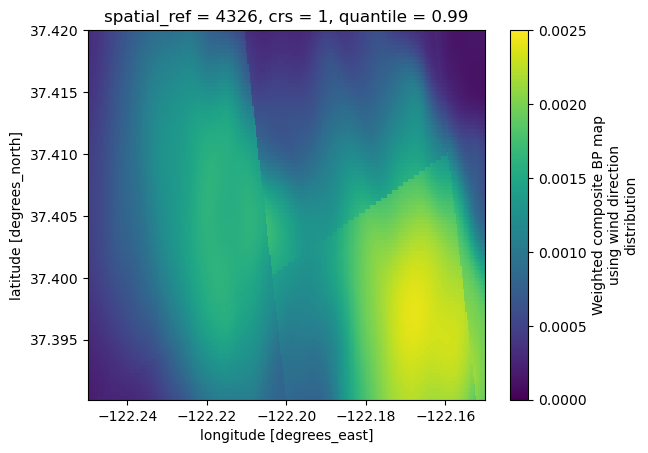

In [8]:
wind_informed_bp_30m_4326.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

# example of what it looks like using a filter from one direction and the first iteration

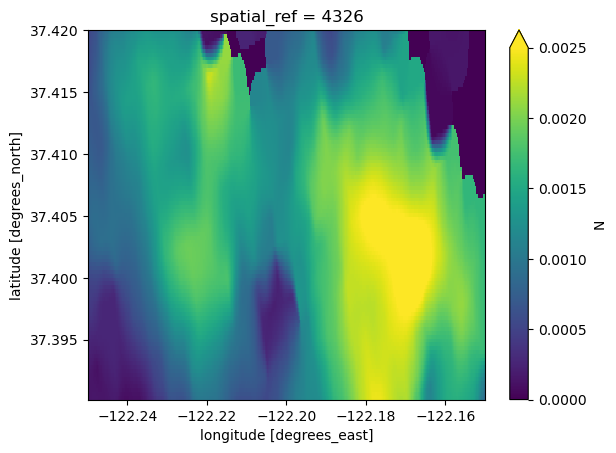

In [156]:
out_dict[0]['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

# second iteration

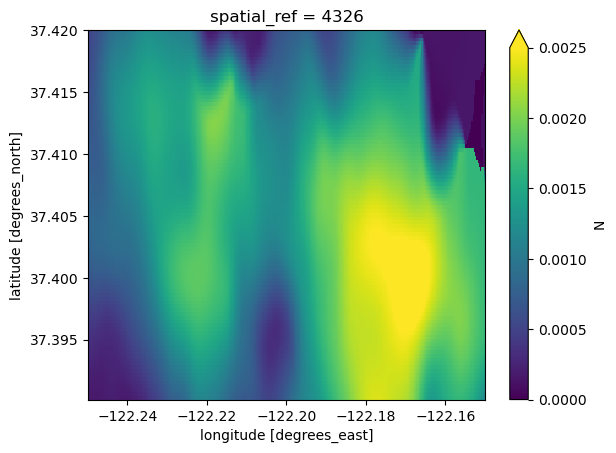

In [157]:
out_dict[1]['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

# third iteration

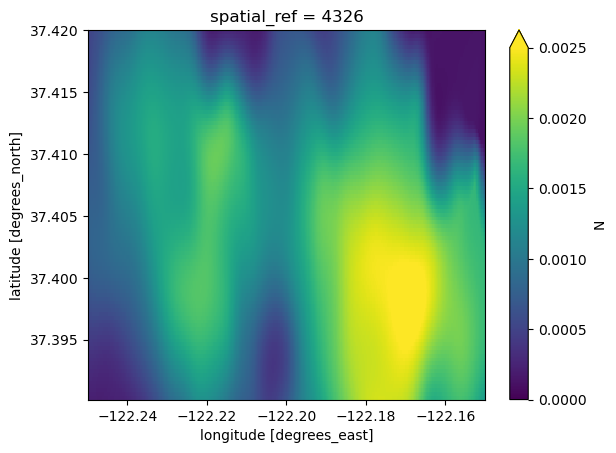

In [158]:
out_dict[2]['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

In [22]:
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(wind_informed_bp_30m_4326, 
                                          how=riley_2011_270m_5070_subset.odc.geobox, 
                                          resampling='average')
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})
riley_filled_270m_5070 = xr.where(riley_2011_270m_5070_subset.BP==0, wind_informed_bp_270m_5070, riley_2011_270m_5070_subset) 
riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
riley_filled_30m_4326 = xr_reproject(riley_filled_270m_5070, 
                                     how=wind_informed_bp_30m_4326.odc.geobox, 
                                     resampling='cubic',
                                     resolution='same')
riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})
reprojected_riley = reprojected_riley.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid
wind_informed_bp_corrected = xr.where(
    reprojected_riley>0, riley_filled_30m_4326, wind_informed_bp_30m_4326
)

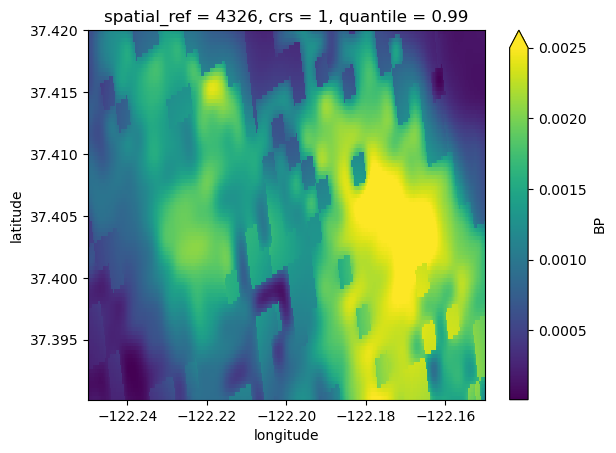

In [79]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot(vmax=0.0025)

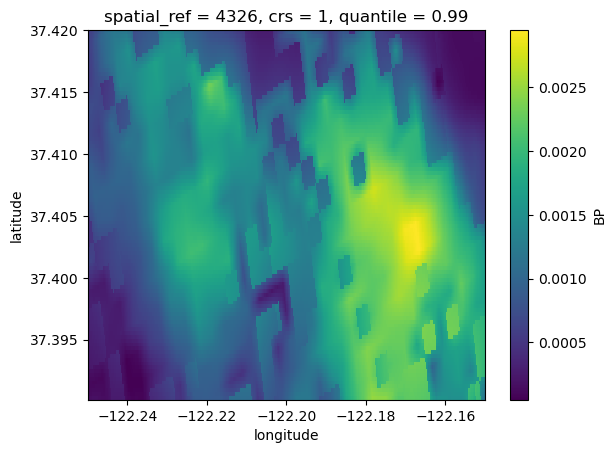

In [73]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

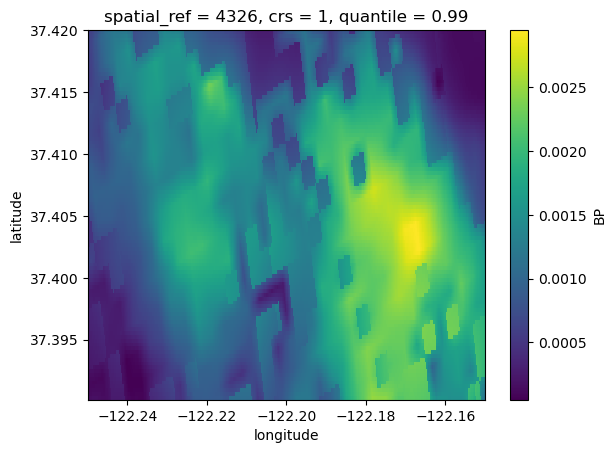

In [71]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

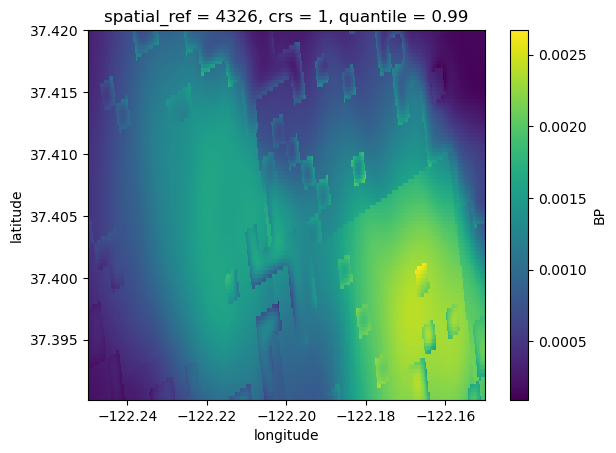

In [61]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

# try all of this but with a gap-filled Riley


- tried it with gapfilling using the function below - too much smoothing!
- next up try doing it only filling a one pixel max - rioxarray interpolate_na and then make a "max 1 more" mask by doing ffill and bffil in both directions by 1 on riley
- mask = riley.ffill(max=1, dim'x') + riley.ffill(max=1, dim'y') + riley.bfill(max=1, dim'x') + riley.bfill(max=1, dim'y') + 
- interpolated_riley = intperolated_riley.where(mask > 0, intperolated_riley, 0)

In [80]:
def gap_fill_270(da):
    da = xr.where(da==0, np.nan, da)
    da = da.rolling({"x":3,"y":3}, center=True, min_periods=1).mean(skipna=True)
    da = da.rolling({"x":3,"y":3}, center=True, min_periods=1).mean(skipna=True)
    da = da.fillna(0)
    return da

In [82]:
import numpy as np
gap_filled_riley_5070 = gap_fill_270(riley_2011_270m_5070_subset)


In [93]:
gap_filled_riley_5070['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs

In [95]:
reprojected_riley_gapfilled = xr_reproject(gap_filled_riley_5070, 
                 how=riley_2011_30m_4326_subset.odc.geobox, 
                 resampling='nearest',
                 resolution='same')

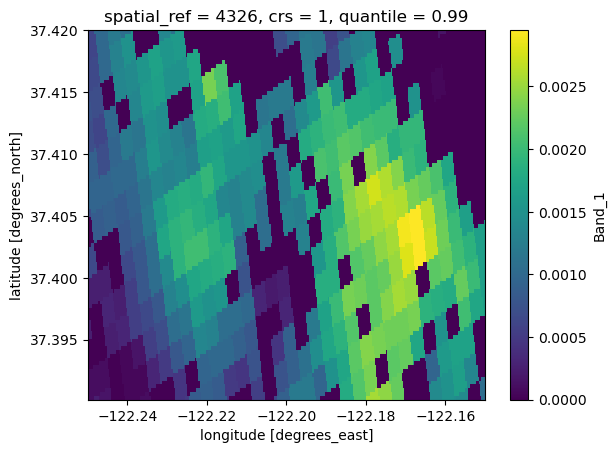

In [98]:
reprojected_riley.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

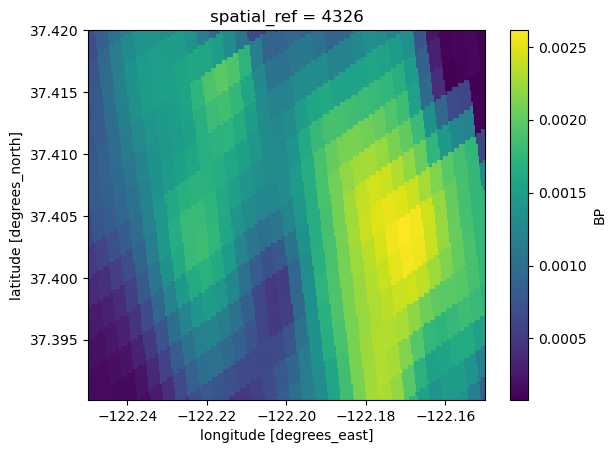

In [96]:
reprojected_riley_gapfilled.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

In [97]:
three_iterations, out_dict = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

three_iterations = three_iterations.assign_coords({'latitude': wind_direction_distribution_30m_4326.latitude,
                                                                 'longitude': wind_direction_distribution_30m_4326.longitude})
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(three_iterations, wind_direction_distribution_30m_4326)
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(wind_informed_bp_30m_4326, 
                                          how=riley_2011_270m_5070_subset.odc.geobox, 
                                          resampling='average')
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})
riley_filled_270m_5070 = xr.where(riley_2011_270m_5070_subset.BP==0, wind_informed_bp_270m_5070, riley_2011_270m_5070_subset) 
riley_filled_270m_5070 = assign_crs(riley_filled_270m_5070, 'EPSG:5070')
riley_filled_30m_4326 = xr_reproject(riley_filled_270m_5070, 
                                     how=wind_informed_bp_30m_4326.odc.geobox, 
                                     resampling='cubic',
                                     resolution='same')
riley_filled_30m_4326 = riley_filled_30m_4326.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})
reprojected_riley = reprojected_riley.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid


here2


In [104]:
reprojected_riley_gapfilled = reprojected_riley_gapfilled.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})

In [105]:
wind_informed_bp_corrected = xr.where(
    reprojected_riley_gapfilled>0, riley_filled_30m_4326, wind_informed_bp_30m_4326
)

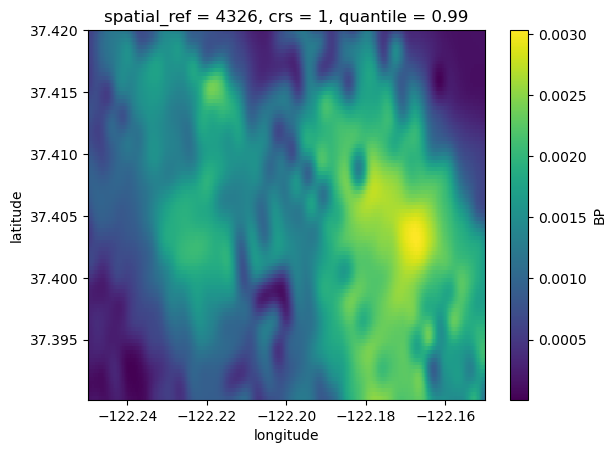

In [106]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

# gapfilling more restricted

In [21]:
import rioxarray
import numpy as np

In [13]:
bbox = [-122.25, 37.39, -122.15, 37.42]


In [34]:
riley_bp_original = riley_2011_270m_5070_subset

In [35]:
riley_2011_270m_5070_subset_nans = xr.where(riley_bp_original==0, np.nan, riley_bp_original)

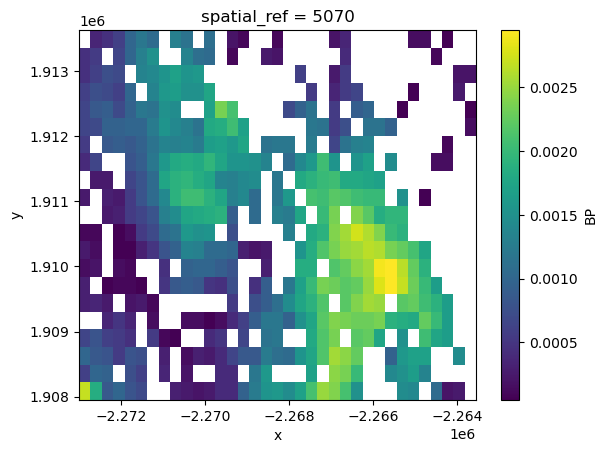

In [45]:
geo_sel(riley_2011_270m_5070_subset_nans.bfill(dim='x', limit=1), 
           bbox= bbox,
           crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt']).BP.plot()

In [65]:
def gap_fill(da):
    da = da.rio.write_nodata(np.nan)
    interpolated = da.rio.interpolate_na('cubic')
    mask_of_one_pixel_buffer_filled = interpolated.bfill(dim='x', limit=1).fillna(0) + interpolated.ffill(dim='x', limit=1).fillna(0) + \
        interpolated.bfill(dim='y', limit=1).fillna(0) + interpolated.ffill(dim='y', limit=1).fillna(0)
    return xr.where(mask_of_one_pixel_buffer_filled> 0, interpolated, 0)

In [66]:
import rioxarray as rio

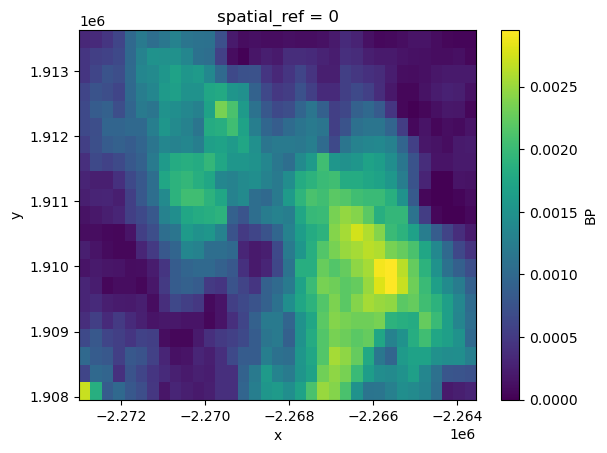

In [70]:
gap_filled = gap_fill(riley_2011_270m_5070_subset_nans['BP'])
geo_sel(gap_filled, 
           bbox= bbox,
           crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt']).plot()

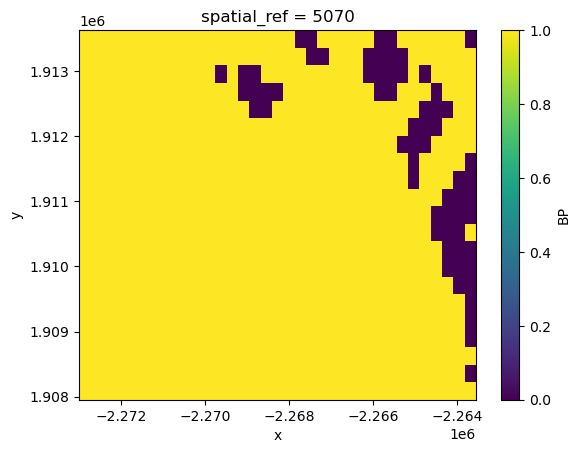

In [50]:
geo_sel(gap_fill(riley_2011_270m_5070_subset_nans), 
           bbox= bbox,
           crs_wkt=riley_2011_270m_5070.spatial_ref.attrs['crs_wkt']).BP.plot()

In [51]:
filling_mask['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs

In [73]:
gap_filled = gap_filled.to_dataset(name='BP')

In [86]:
three_iterations, out_dict = apply_wind_directional_convolution(reprojected_riley.BP, iterations=3)

three_iterations = three_iterations.assign_coords({'latitude': wind_direction_distribution_30m_4326.latitude,
                                                                 'longitude': wind_direction_distribution_30m_4326.longitude})
wind_informed_bp_30m_4326 = create_weighted_composite_bp_map(three_iterations, wind_direction_distribution_30m_4326)
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
wind_informed_bp_30m_4326 = assign_crs(wind_informed_bp_30m_4326, 'EPSG:4326')
## average wind_informed_bp to 270m
wind_informed_bp_270m_5070 = xr_reproject(wind_informed_bp_30m_4326, 
                                          how=riley_2011_270m_5070_subset.odc.geobox, 
                                          resampling='average')
##  put non-zero numbers into where zero numbers were before
# riley_2011_270m_5070_subset = riley_2011_270m_5070_subset.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
#                                                                  'longitude': wind_informed_bp_30m_4326.longitude})

here2


/Users/orianachegwidden/ocr/ocr/risks/fire.py:181: RuntimeWarning: invalid value encountered in divide
  arr = np.where(convolved_mask > 0, convolved_arr / convolved_mask, 0.0)


In [105]:
# reprojected_riley_gap_filled = assign_crs(reprojected_riley_gap_filled, 'EPSG:5070')
gap_filled['spatial_ref'].attrs = riley_2011_270m_5070_subset['spatial_ref'].attrs
reprojected_riley_gap_filled = xr_reproject(gap_filled, 
                 how=riley_2011_30m_4326_subset.odc.geobox, 
                 resampling='cubic',
                 resolution='same')
reprojected_riley_gap_filled = reprojected_riley_gap_filled.assign_coords({'latitude': wind_informed_bp_30m_4326.latitude,
                                                             'longitude': wind_informed_bp_30m_4326.longitude})
# retain original Riley et al. (2025) burn probability, reprojected and interpolated to a 30m EPSG:4326 grid

In [106]:
wind_informed_bp_corrected = xr.where(
    reprojected_riley_gap_filled>0, reprojected_riley_gap_filled, wind_informed_bp_30m_4326
)

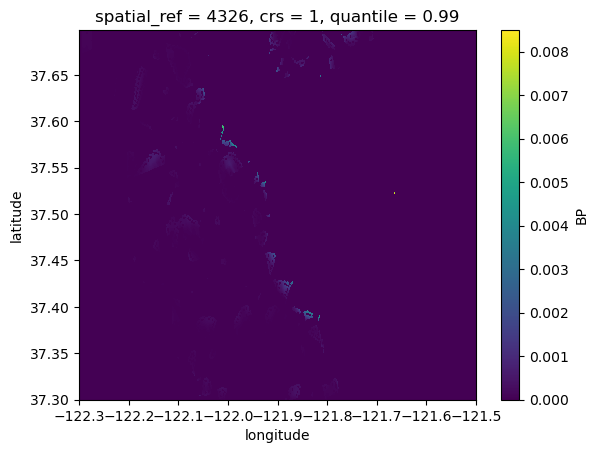

In [117]:
(wind_informed_bp_corrected-reprojected_riley_gap_filled).sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

In [116]:
bbox = [-122.3, 37.3, -121.5, 37.9]

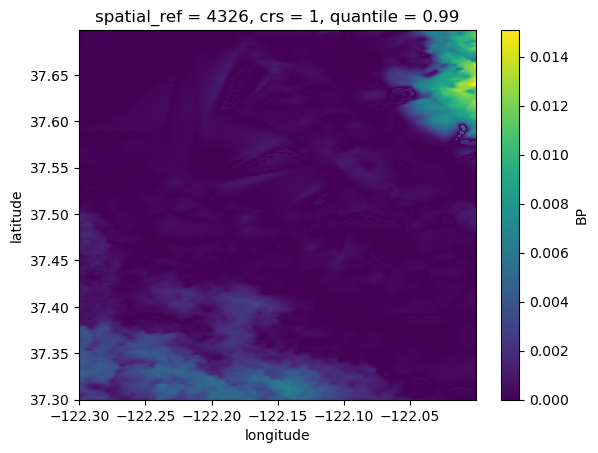

In [112]:
wind_informed_bp_corrected.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).BP.plot()

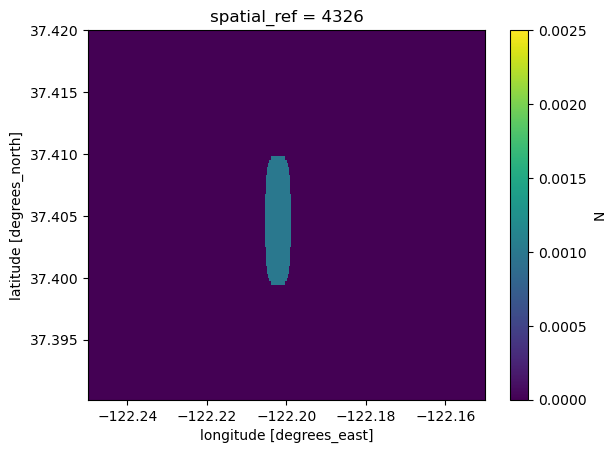

In [133]:
bbox = [-122.25, 37.39, -122.15, 37.42]

spread_results['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

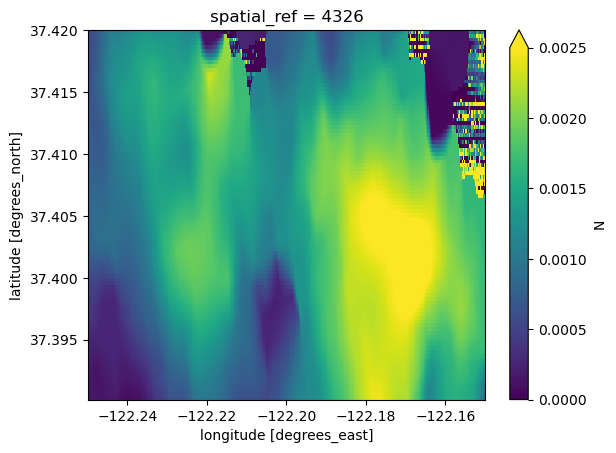

In [21]:
bbox = [-122.25, 37.39, -122.15, 37.42]

one_iteration['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

In [22]:
two_iterations = apply_wind_directional_convolution(reprojected_riley.BP, iterations=2)

here
ERROR! Session/line number was not unique in database. History logging moved to new session 201


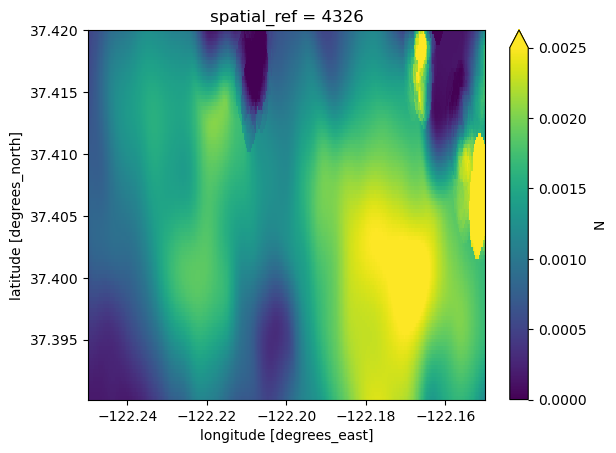

In [23]:
two_iterations['N'].sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmin=0, vmax=0.0025)

In [101]:
bbox = [-122.18, 37.41, -122.15, 37.42]
spread_results, convolved_mask, convolved_arr, arr, valid_mask = apply_wind_directional_convolution(reprojected_riley.BP.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])), iterations=1)

here
her
her
her
her
her
her
init
her
her


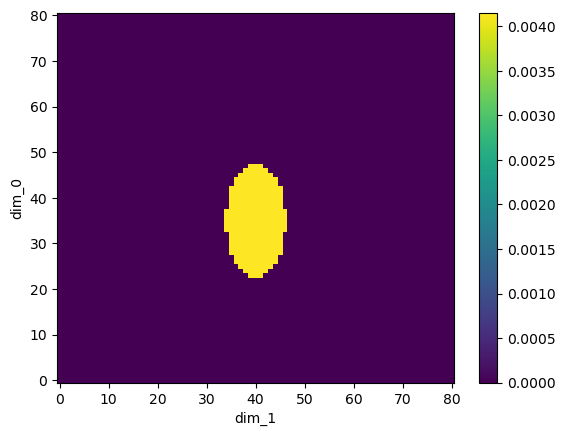

In [110]:
xr.DataArray(weights_dict['N']).plot()

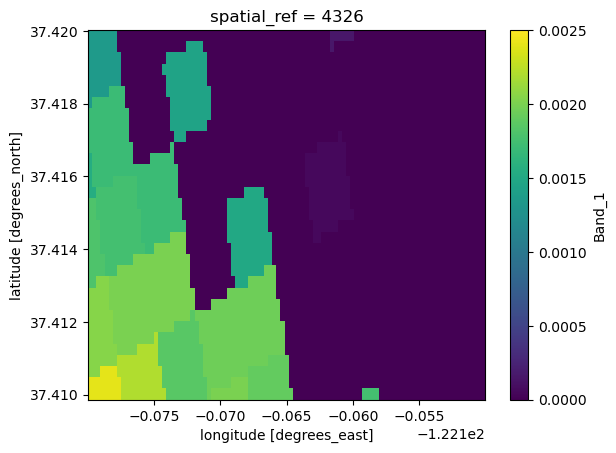

In [108]:
reprojected_riley.BP.sel(latitude=slice(bbox[3], bbox[1]), longitude=slice(bbox[0], bbox[2])).plot(vmax=0.0025)

In [111]:
spread_results['N'].shape

(33, 97)

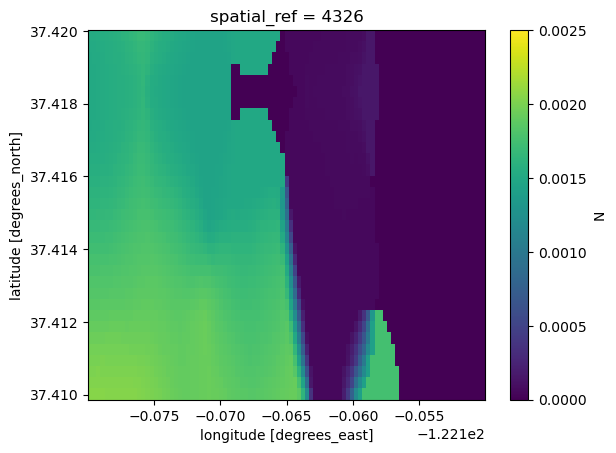

In [109]:
spread_results['N'].plot(vmax=0.0025)

In [118]:
xr.DataArray(valid_mask).plot()

NameError: name 'valid_mask' is not defined

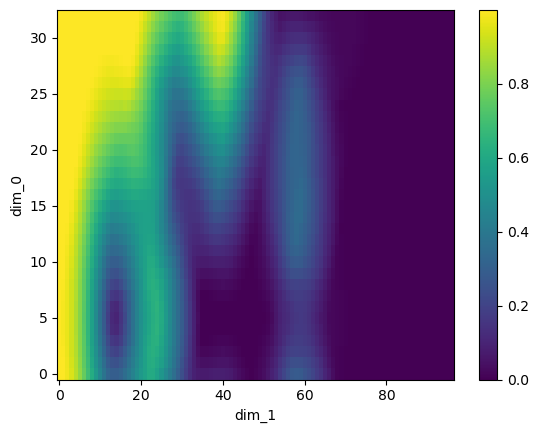

In [105]:
xr.DataArray(convolved_mask).plot()

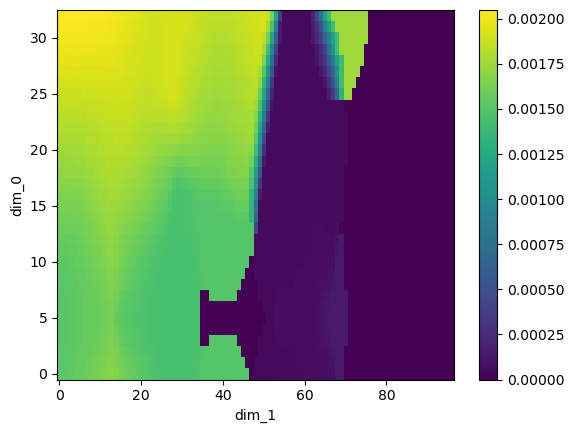

In [106]:
(xr.DataArray(arr)).plot()

In [67]:
xr.DataArray(arr).max()#.plot()

<xarray.DataArray ()> Size: 8B
array(0.08398437)

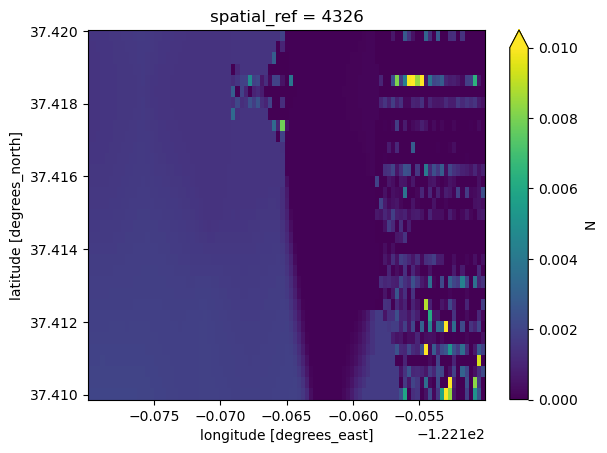

In [35]:
one_iteration['N'].plot(vmax=0.01)

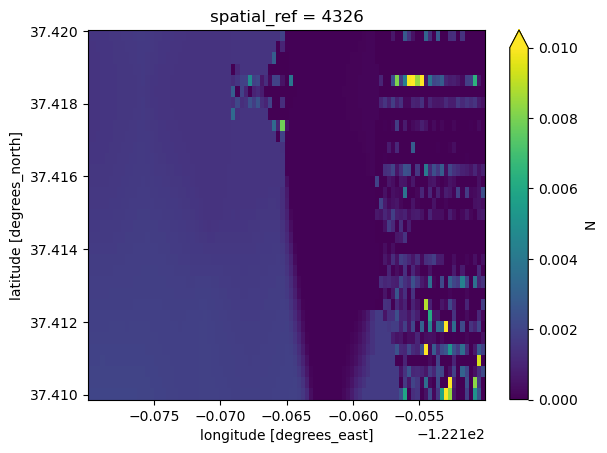

In [38]:
one_iteration['N'].plot(vmax=0.01)